# Copernicus DEM on AWS Open Data

## Accessing Cloud Optimized Raster Data

With the AWS ASDI STAC API we can search and load various geospatial datasets. Below we'll work with the Copernicus GLO-30 Digital Elevation Model, sourced from Cloud Optimized GeoTIFFs (COGs) hosted on AWS. In this example, we read in elevation data using a bounding box.

First we install any necessary packages. Please note that the following block of code only needs to be run if needed within a new workspace and that you may need to restart the kernel to use updated packages. The code block only needs to be run once for each AWS Sagemaker Studio profile.

In [1]:
%pip install --upgrade pip -q
%pip install matplotlib pystac_client stackstac rasterio folium geopandas -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


We'll use `pystac_client` to submit our search query, stackstac to load and composite our rasters as an Xarray DataArray, and rio-tiler to performantally load individual COGs.

### Querying the AWS STAC API with Pystac Client

First, we define the URL to our STAC API, a service that allows us to submit search queries for spatio-temporal assets (like elevation raster tiles).

Next, we open this URL with `pystac_client`, which allows us to use the client's search method. `client.search` accepts many different arguments to specify the search query. Common query parameters are `time_range` and `bbox` (the spatial bounding box). Since the DEM was collected at one point in time, we will only specify the "where" with a `bbox` describing the minx, miny, maxx, maxy coordinates in lat/lon degrees.

In [2]:
import os
from pystac_client import Client
import stackstac
# making a connection to AWS STAC API
API_ROOT_URL = "https://dev.asdi-catalog.org"
client = Client.open(API_ROOT_URL)

# our search requirements, a bounding box for San Ignacio. Belize
bbox = [-89.19605011359278, 17.028707271735962, -88.94369134663197, 17.263285211322446]
source_search = client.search(
        collections=["cop-dem-glo-30"], bbox=bbox
    )
# getting the metadata and links to data assets in STAC format
source_items = source_search.get_all_items()
print("Number of elevation tiles: ", len(source_items))

Number of elevation tiles:  2


### Loading an OpenStreetMap(OSM) descriptive map of the same area

To better understand our area of interest, we can create a descriptive map with our bounding box. We'll load an OpenStreetMap basemap that includes place names, annotations for water and forested areas, and roads. We'll use `folium` to access and plot this map. To learn more about `folium`, check out the [documentation](https://python-visualization.github.io/folium/). We'll use our bounding box to specify where we want to center our map and pick a zoom level that shows us detail around San Ignacio.

In [3]:
# import geopandas to work with geospatial data
import geopandas as gpd
# import shapely for manipulation and analysis of geometric objects
import shapely as shp
bbox_poly = shp.geometry.box(*bbox)
center_point = (bbox_poly.centroid)

In [4]:
import folium
m = folium.Map(location=[center_point.y, center_point.x], zoom_start=9)
folium.GeoJson(source_items.to_dict(), name="items").add_to(m)
bbox_style = {'fillColor': '#ff0000', 'color': '#ff0000'} #make bbox red
folium.GeoJson(bbox_poly, name="bbox", style_function=lambda x:bbox_style).add_to(m)
m

### Loading DEM raster into an Xarray DataArray

There are multiple options for loading STAC items into in-memory arrays. `stackstac` allows you to specify a list of items from a `pystac_client` search and load those items as a single xarray DataArray. Similar to it's name, `stackstac` handles loading and then stacking individual COGs that fall within our `pystac` query. Since our `stack` DataArray has two tiles, we need to composite the tiles within the bounding box into one raster.

In [5]:
# converting STAC items into an xarray data array
stack = stackstac.stack(source_items, epsg = 4326)

print(type(stack))

stack

<class 'xarray.core.dataarray.DataArray'>


<xarray.DataArray 'stackstac-0058008325b3176f6b45a86bbfc03d95' (time: 2,
                                                                band: 1,
                                                                y: 3601, x: 7201)>
dask.array<fetch_raster_window, shape=(2, 1, 3601, 7201), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 2021-04-22 2021-04-22
    id          (time) <U40 'Copernicus_DSM_COG_10_N17_00_W090_00_DEM' 'Coper...
  * band        (band) <U4 'data'
  * x           (x) float64 -90.0 -90.0 -90.0 -90.0 ... -88.0 -88.0 -88.0 -88.0
  * y           (y) float64 18.0 18.0 18.0 18.0 18.0 ... 17.0 17.0 17.0 17.0
    gsd         float64 30.0
    proj:epsg   float64 4.326e+03
    platform    <U8 'TanDEM-X'
    license     <U11 'proprietary'
    proj:shape  object {3600.0}
    epsg        int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-90.00027777777778, 17.0, -88....
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-90.00|\n| 0.00,-0.00, 18.00|\n| 0.00, 0.00, 1.00|
    resolution:  0.0002777777777777778

We'll load this into memory so that later operations that use this array are faster.

In [6]:
import rasterio
from dask.diagnostics import ProgressBar

with ProgressBar() and rasterio.Env(AWS_NO_SIGN_REQUEST=True):
    stack = stack.compute()

Before compositing, let's first plot the tiles individually tile to see if there are any nodata values we need to handle. A DataArray's plot method gives us a quick look at the raster.

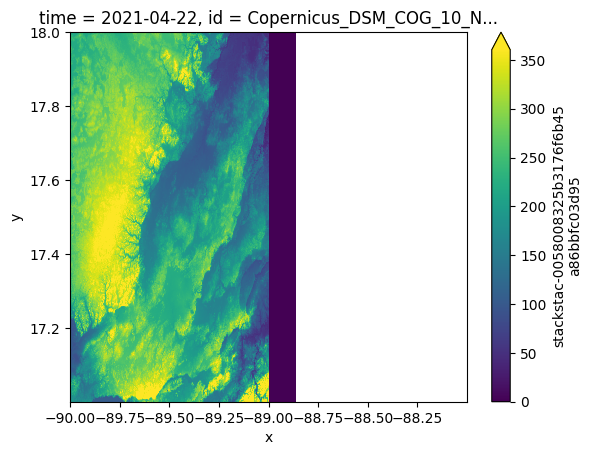

In [7]:
import matplotlib
stack.isel(time=0).plot(cmap="viridis", robust=True)

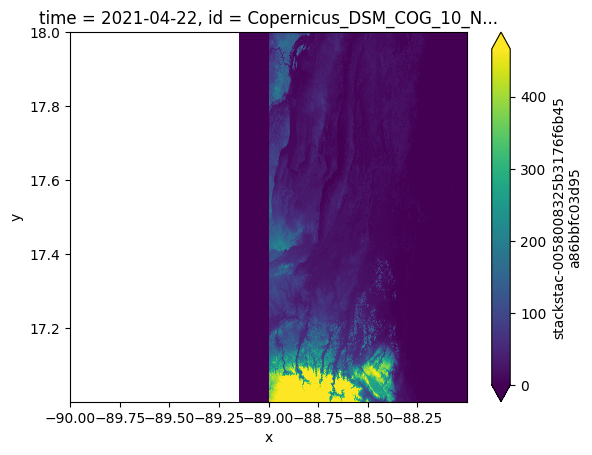

In [8]:
stack.isel(time=1).plot(cmap="viridis", robust=True)

It looks like 0 is the nodata value, which is evident by the hard boundary between 0 valued pixels and data pixels. We can mask these nodata areas with the `where` method so that they don't affect the composite calculation.

In [9]:
stack = stack.where(stack!=0)

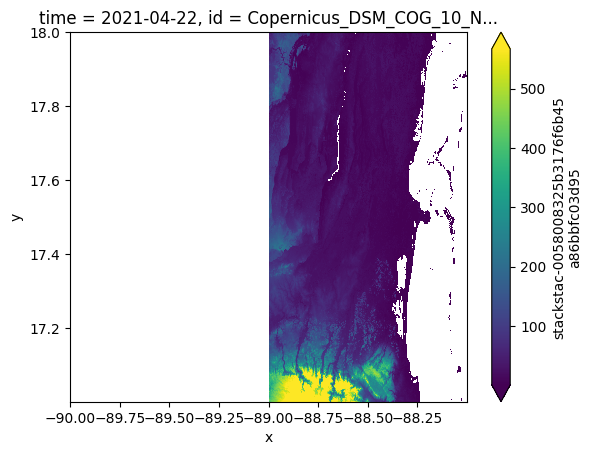

In [10]:
stack.isel(time=1).plot(cmap="viridis", robust=True)

Below we compute a mean composite between the two tiles.

In [11]:
# taking the mean along the time dimension to combine the two elevation tiles
composite = stack.mean(dim="time")
composite

<xarray.DataArray 'stackstac-0058008325b3176f6b45a86bbfc03d95' (band: 1,
                                                                y: 3601, x: 7201)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan, 216.86097717, 217.20933533, ...,          nan,
                  nan,          nan],
        [         nan, 218.82432556, 220.06520081, ...,          nan,
                  nan,          nan],
        ...,
        [         nan, 199.19949341, 198.58366394, ...,          nan,
                  nan,          nan],
        [         nan, 204.44692993, 202.72372437, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * band        (band) <U4 'data'
  * x           (x) float64 -90.0 -90.0 -90.0 -90.0 ... -88.0 -88.0 -88.0 -88.0
  * y           (y) float64 18.0 18.0 18.0 18.0 18.0 ... 17.0 17.0 17.0 17.0
    gsd         float64 30.0
    proj:epsg   float64 4.326e+03
    platform    <U8 'TanDEM-X'
    license     <U11 'proprietary'
    proj:shape  object {3600.0}
    epsg        int64 4326

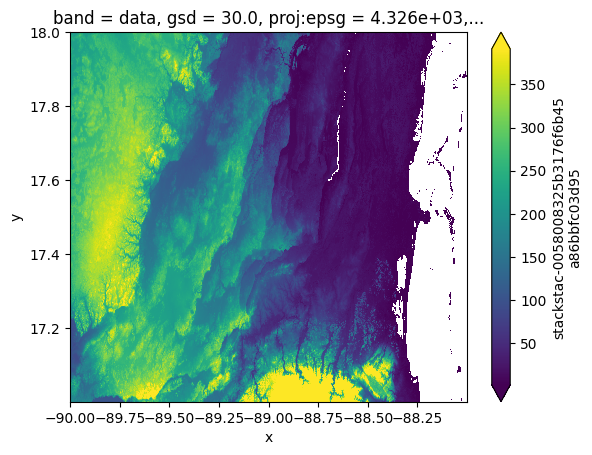

In [12]:
composite.plot(cmap="viridis", robust=True)

In the above plot, we can see the elevation contour of the Mopan river, which flows near San Ignacio from the north to the southwest corner of our bounding box.